# Predictive Data Analytics for Urban Footfall

Authors: [Nick Malleson](http://nickmalleson.co.uk/) ([School of Geographym, University of Leeds](http://geog.leeds.ac.uk/)), Molly Asher ([Leeds Institute for Data Analytics](http://lida.leeds.ac.uk/)) and Simon Brereton ([Leeds City Council](http://leeds.gov.uk/)).

_This document summarises the work of the 'Predictive Data Analytics for Urban Footfall' project_

## Project Summary

An understanding of what attracts people to city centres, and what discourages them, is vital for city councils and other planning agencies in order to attract a larger number of visitors to their city centres. Understanding the factors that drive footfall is also of substantial academic interest, particularly around questions of mobility, inclusivity, and of accessibility of opportunities.

To better quantify footfall, Leeds City Council has installed some CCTV cameras that count the number of people who walk past them in hourly intervals. Data from these cameras are available dating back to 2008, and therefore give a reasonable picture of how the number of visitors to the city centre has changed over time. There is great potential to leverage these data as both an explanatory tool for understanding what has been driving city-centre attendance and as a predictive tool for forecasting future footfall under different scenarios. 

**This report documents one of the major aspects of the project: the development of a machine learning algorithm to predict footfall based on relevant exogonous factors.**

## Table of Contents

 - [Introduction](#intro)
 - [Background / Context](#background)
 - [Data](#data)
 - [Method - background](#methodbackground)
 - [Method - machine learning for footfall](#method)
 - [Results](#results)
 - [Conclusions](#conclusions)


## TODO

 - Tidy code so that the `FOOTFALL_FILE` isn't read more than once
 - Work out why some of the errors in the tests for LinearRegression explode. This happens with both mse and r2.
 

## Required Packages

 - pandas
 - numpy
 - scikit-learn
 - xgboost

## Code Initialisation

Start by importing the packages required throughout and defining some global variables

In [1]:
## Load the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import copy
import datetime
import time as thetime # (I know it's messy to rename as 'thetime', but 'time' is used elsewhere)
import operator # So that it is possible to sort a dictionary on the values

import multiprocessing
from multiprocessing import Pool # To run models in multiple threads simultaneously

# To display tables in HTML output
from IPython.display import HTML, display

# Tell the notebook to do inline charts
%matplotlib inline

# The location of the data
FOOTFALL_FILE = "footfall_data/footfall.csv"

<a id="intro"></a>
## Introduction

XXXX

<a id="background"></a>
## Background

### Footfall

XXXX

### Machine Learning for Footfall Estimation

XXXX


<a id="data"></a>
## Data

XXXX Information about the data sources

### Weather

XXXX

### School, University, and Public Holidays

XXXX

### Functions to analyse the data

Begin the data analysis by defining some useful python functions

In [14]:
""" Define function for splitting dataframe into time segments.
    For each it is grouped by that time fragment and then sorted
    to be in ascending order. """
    
def segment_time (file):
    #file = total_results.loc[total_results['LocationName'] == file]
    ################### Group by year
    year = pd.DataFrame(file, columns = ['Year', 'InCount'])
    year = year.groupby('Year', as_index=False).sum()    

    ################### Group by month
    month = pd.DataFrame (file, columns = ['Month', 'Year', 'InCount', 'Month_yr'])
    month = month.groupby(['Year', 'Month', 'Month_yr'], as_index=False).sum()  
    # Sort
    month = month.sort_values(by=["Year","Month"], ascending=[True, True])
    month = pd.DataFrame(month, columns = (['Month_yr','InCount']))

    ################### Group by week
    week = pd.DataFrame(file, columns = ['BRCWeek', 'Year',  'InCount', 'Week_yr'])
    week = week.groupby(['Week_yr','Year'], as_index=False).sum() 
    # Sort
    week = week.sort_values(by=['Year', 'Week_yr'],ascending=[True, True] ) 
      # Keep only relevant fields
    week = pd.DataFrame(week, columns = (['Week_yr','InCount']))
    
     ################### Group by week type 2
    week_custom = pd.DataFrame(file, columns = ['week_no', 'Year',  'InCount', 'Week_yr'])
    week_custom = week_custom.groupby(['week_no','Year'], as_index=False).sum() 
    # Sort
    week_custom = week_custom.sort_values(by=['Year', 'week_no'],ascending=[True, True] ) 
      # Keep only relevant fields
    week_custom = pd.DataFrame(week_custom, columns = (['week_no','InCount']))
    
    ################### Group by day
    day = pd.DataFrame(file, columns = ['Day', 'Month','Year', 'InCount', 'NewDate'])
    day = day.groupby(['Day','Month', 'Year', 'NewDate'], as_index=False).sum()    
    # Sort
    day = day.sort_values(by = ['Year', 'Month', 'Day'], ascending=[True, True, True])
    # Keep only relevant fields
    day = pd.DataFrame (day, columns = ['NewDate','InCount'])
    
     ################### Group by hour
    hour = pd.DataFrame(file, columns = ['InCount','Hour_yr', 'Hour', 'NewDate'])
    # Group by hour
    hour = hour.groupby(['NewDate', 'Hour'], as_index=False).sum()
    # Sort
    hour = hour.sort_values(by = ['NewDate', 'Hour'], ascending=[True, True])
    # reoder to hour comes first
    hour = hour[['Hour', 'InCount', 'NewDate']]
    
    # Store the results in a dictionary
    time_dico = {'Year': year, 'Month': month, 'Week': week, 'Day': day, 'week_custom': week_custom, 'Hour': hour}

    return time_dico

# Function to process date and recreate it in a different format
def create_date_format (col, old_time_format, new_time_format):
    col = pd.to_datetime(col, format = old_time_format )
    if type(col) == pd.core.series.Series:
        col = col.apply(lambda x: x.strftime(new_time_format))
    elif type(col) ==  pd.tslib.Timestamp:
        col = col.strftime(new_time_format)
    return col  


""" Final functions calling all other functions and producing dictionaries of dataframes """

# Creates a dictionary containing for each time segment and location a dataframe with dates and counts
def create_dico_of_results (f, time_of_day):
    # overall_counts  = pd.read_csv("Footfall Data/Cleaned Footfall Data/sb_results.csv")
    overall_counts  = pd.read_csv(f)
    # Create splits based on hours of day
    if time_of_day == 'day':
         overall_counts = overall_counts.loc[overall_counts['Hour'].isin(list(range(8,18)))]
    elif time_of_day == 'evening':
         overall_counts = overall_counts.loc[overall_counts['Hour'].isin(list(range(18,21)))] 
    elif time_of_day == 'night':
         overall_counts = overall_counts.loc[overall_counts['Hour'].isin([21,22,23,24,0,1,2,3,4,5,6,7])] 
    locations = list(overall_counts.LocationName.unique())
    final_dico = {}
    for Location in locations:
        location_breakdown = overall_counts.loc[overall_counts['LocationName'] == Location]
        results = segment_time (location_breakdown)
        for (k,v) in results.items():   
            # Save the results to an overall springboard results dictionary
            name = k + '-' + Location
            final_dico[name] = v                  
    return final_dico    

# Creates a dictionary containing for each time segment a dataframe with dates and total counts across all locations
def create_totals_dico(f):
    file = pd.read_csv(f)
    total = segment_time(file)
    times = ['Hour', 'Day', 'Week', 'week_custom', 'Month', 'Year']    
    totals_dico = {}
    for Time in times:
        total_time_split = total[Time]
        totals_dico[Time] = total_time_split
    return totals_dico        

def create_aggregated_dico(input_dico):   
    aggregated_dico = copy.deepcopy(input_dico)
    aggregated_counts_dico = {}
    for (k,v) in aggregated_dico.items():
        timeframe_column =v.columns[0] 
        if k == 'Day': 
                 v[timeframe_column] = create_date_format(v[timeframe_column], '%d-%b-%Y', '%A' ) 
        elif k == 'Year' or k == 'Hour' or  k == 'week_custom':      
                 v[timeframe_column] = v[timeframe_column]  
        else:                         
            v[timeframe_column] = v[timeframe_column].apply(lambda x: x.split('-')[0])   
        grouped = v.groupby([timeframe_column], as_index = False).mean()
        sort = grouped.sort_values(by=['InCount'], ascending = [False])
        aggregated_counts_dico[k] = sort
    return aggregated_counts_dico

def prepare_to_plot (file, dico):
    location = dico[file]
    location = location.reset_index (drop = True)
    location.count = location['InCount']
    return location

# Save values above and below normal
def find_strange_points (data):
    above_twostd = data.loc[data['InCount']> twostd_above_mean]
    below_twostd = data.loc[data['InCount'] < twostd_below_mean]
    anomolies[location + '_above'] = above_twostd 
    anomolies[location + '_below'] = below_twostd  
    
    
def make_ticks (file):
    t = file.iloc[:,0]
    ticks = list(t.values.flatten())
    if len(t) <= 10: 
           ticks = ticks
           tick_locations =  [i for i in range(0,len(t))]
    else: 
           ticks = [ticks[i] for i in range(0,len(t),int(len(t)/10))]
           tick_locations =  [i for i in range(0,len(t),int(len(t)/10))]
    return (ticks, tick_locations)        

### Temporal Variation in Footfall

_Taken from:_

 - `Exploring temporal variation in footfall.docx`
 - `subplots.py` (this file also has lots of graphs for the different cameras)

Examination of historical records from Leeds City Centre demonstrate that the footfall level is variable at a number of temporal scales. One of the most prominent patterns that is observed is the change in footfall levels taking place within the scale of a week. A gradual increase is seen from Monday through Friday, with footfall levels then jumping markedly on Saturday before falling to a level significantly lower than the mean on Sunday. 

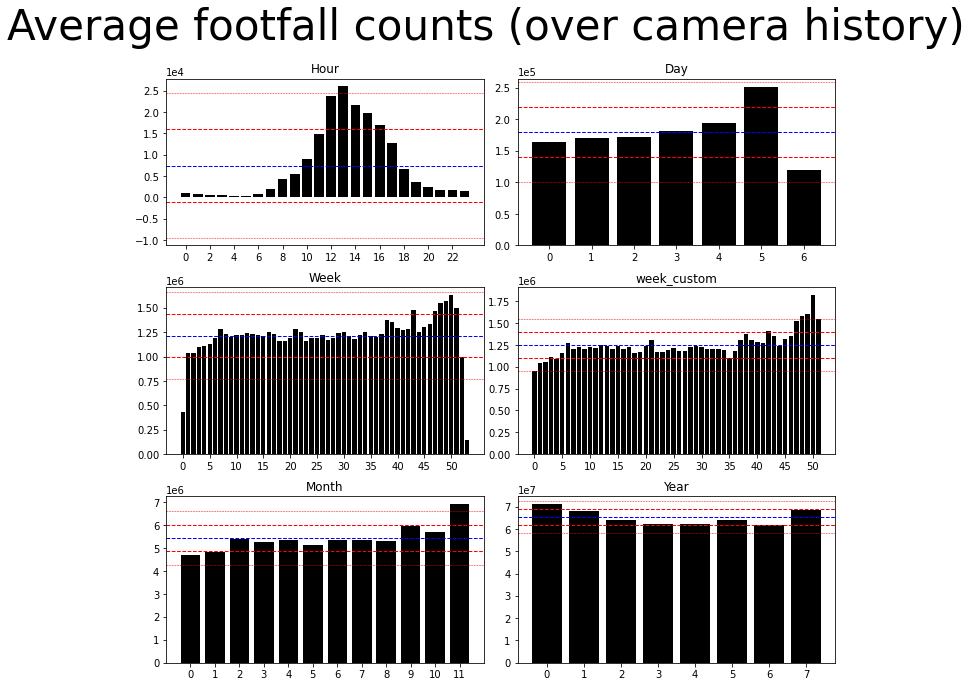

In [113]:
''' Make bar charts showing averages over the life history of the cameras.
    E.g. the average footfall of all of the Mondays, Tuesdays, Wednesdays ever.'''

# Check that the footfall file is available


# Create the dictionary of results for each location and time
try:
    totals_dico = create_totals_dico(FOOTFALL_FILE)  
    aggregated_counts_dico = create_aggregated_dico(totals_dico)  
except FileNotFoundError as e:
    raise FileNotFoundError("Error: could not find the footfall file '{}'.\nHave you uncompressed the zip file?".format(FOOTFALL_FILE))

# Put in chronological order for plotting
aggregated_counts_sorted_dico = {}
for (k,v) in aggregated_counts_dico.items():
    if k == 'Day':
        v = v.reset_index (drop = True)
        v = v.reindex([5,4,3,2,1,0,6])
        v.rename(columns={"NewDate": "Day"},inplace = True)
    elif k == 'Week':   
        v = v.sort_values(by = 'Week_yr', ascending = True)
        v.rename(columns={"Week_yr": "Week"},inplace = True)
    elif k == 'week_custom':   
        v = v.sort_values(by = 'week_no', ascending = True)
        v.rename(columns={"week_no": "week_custom"},inplace = True)
    elif k ==  'Month':     
        v = v.reindex([4,3,7,0,8,6,5,1,11,10,9,2])
        v = v.reset_index (drop = True)        
        v.rename(columns={"Month_yr": "Month"},inplace = True)
    elif k ==  'Year': 
        v = v.sort_values(by = 'Year', ascending = True)
        v = v.reset_index (drop = True)   
    elif k ==  'Hour': 
        v['Hour'] = v['Hour'].astype(int)
        v = v.sort_values(by = 'Hour', ascending = True)
        v = v.reset_index (drop = True)
    aggregated_counts_sorted_dico [k] = v
#del (aggregated_counts_dico)       

# Create a figure with 6 subplots
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
subset = [k for k,v in aggregated_counts_sorted_dico.items()]
for time,index in zip(subset, list([(i,j) for i in range(4) for j in range(2)])):
    # Prepare the data for plotting
    processed_data = prepare_to_plot(time, aggregated_counts_sorted_dico)
    if processed_data.columns[0] == 'Day_yr':
         processed_data['Day_yr'] = processed_data['Day_yr'].apply(lambda x: x.split('/')[0])                            
    ticks = make_ticks(processed_data)[0]
    # Calculate mean and std statistics
    mean = processed_data['InCount'].mean()
    std = processed_data['InCount'].std()
    onestd_above_mean = mean + std
    twostd_above_mean = mean + std + std
    onestd_below_mean = mean - std
    twostd_below_mean = mean - std - std
    # Plot
    x_pos = [i for i, _ in enumerate(processed_data[time])]
    ax[index].bar(x_pos, processed_data['InCount'], color = 'black')
    # Formatting   
    title =  time.split('-')[0]
    ax[index].set_title(title)
    ax[index].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')  
    ax[index].set_xticks(processed_data.index)  
#     ax[index].set_xticklabels(ticks, rotation=70)
    ax[index].locator_params(nbins=12, axis='x') 
    # Add mean and standard deviation lines
    ax[index].axhline(mean, color='b', linestyle='dashed', linewidth=1,label='Mean')
    ax[index].axhline(onestd_above_mean, color='r', linestyle='dashed', linewidth=1,label='1 Std above mean')
    ax[index].axhline(onestd_below_mean, color='r', linestyle='dashed', linewidth=1, label='1 Std below mean')
    ax[index].axhline(twostd_above_mean, color='r', linestyle='dashed', linewidth=0.5,label='2 Std above mean')
    ax[index].axhline(twostd_below_mean, color='r', linestyle='dashed', linewidth=0.5, label='2 Std below mean')
    #ax[index].legend()
# Set the title
st = fig.suptitle('Average footfall counts (over camera history)', fontsize=42)
# Adjust the positioning of the title
st.set_y(0.95)
 # Set tight layout 
fig.tight_layout()
# Adjust level of title
fig.subplots_adjust(top= 0.85)
# Delet the 6th plot
#fig.delaxes(ax.flatten()[5])
# Save the figure
#fig.savefig('AverageHistoricalFootfall' + '.png', bbox_inches='tight')
#plt.clf()

plt.show()

Throughout the year footfall levels also vary, and this can be observed by looking at either the average monthly or average weekly footfall levels. Looking at months we can see that footfall levels are at their lowest point in the first two weeks of the year. They are maintained at a fairly stable level between March and September (aside from in July when they dip) and then increase slightly in October and November, before reaching their peak in December.

Breaking down footfall by week shows a more nuanced picture of the change in footfall levels over time. Week numbers were assigned starting with 1st January always being the first day of Week 1, this meant that in different years the same date would always be placed in the same Week(NOTE: realised this isn't quite true as leap years through it out). This shows variation hidden by the months plot, for instance although December has the highest footfall rate, we see here that in fact week 51 has a very high footfall count, and week 52 a much lower one. It’s also easier to observe fine scale differences, such as spikes in week 22 (around the May Bank Holiday weekend) and in week 39 (around when the University term starts). 

The effect of time on footfall is not linear; this is particularly apparent on significant days such as Christmas Day, New Year’s Day and Easter Sunday. These three days have consistently the lowest footfall levels (On Christmas Days levels are consistently below 10,000, compared to values around 150,000 - 200,000 normally). 

### Impact of later shopping hours

_Taken from_:

 - `Impact of later shopping hours.docx`
 - `Exploratory Data Analysis/proportional_footfall_different_locations.py`

To examine how footfall levels have varied annually the total footfall level for each year was compared. This shows that between 2009 and 2016 the annual footfall levels have been variable. Between 2009 and 2012 there was a decrease in footfall, this was followed by several years where levels remained fairly constant before rising again in 2016. 

The opening of the Trinity Centre in Leeds in March 2013 meant that there was an increase in the number of shops in the city centre offering later shopping hours, with Trinity open until 8pm daily. It is thought that this new development with its associated later opening hours, and an encouragement of a switch from retail to leisure might promote an increase in the footfall levels later in the evening. 

To examine this, the percentage of total daily footfall found in the daytime (8am to 6pm), the evening (6pm to 9pm) and the night time (9pm to 8am) was plotted. This showed that the proportion of footfall coming from the daytime hours has an overall downward trend and conversely the footfall count in the evening has been increasing. A step change can be observed at around the 2013 mark. There has also been a slight increase in the proportion of footfall coming from the night time hours, but this rate of increase is much smaller.

Functions that are useful for drawing the charts that show the change in footfall over time.

In [84]:
# Keep only certain hours in the day
def split_day(day, hours_wanted):
    time_split = day.loc[day['Hour'].isin(hours_wanted)]
    return time_split

def make_file (hours_wanted, file):
    #file = file[file.LocationName.str.contains(LocationName) == True]
    day = pd.DataFrame(file, columns = ['Day', 'Month','Year', 'Hour', 'InCount', 'Day_yr'])
    day = split_day(day, hours_wanted)
    del day['Hour']
    day = day.groupby(['Day','Month', 'Year', 'Day_yr'], as_index=False).sum()    
    day['Day_yr'] = day['Day_yr'].apply(lambda x: x.split('/')[1]) 
    day = pd.DataFrame(day, columns = ['Day_yr', 'InCount'])
    day['datetime'] = pd.to_datetime(day['Day_yr'], format = '%d-%b-%Y')
    day = day.sort_values(by = 'datetime', ascending=[1])
    del day['datetime']
    day = day.reset_index(drop = True)
    return(day)

Read the data

In [43]:
# Read the cleaned camera data file
f  = pd.read_csv(FOOTFALL_FILE)

# Produce dataframes with the incount for the wholeday and for each of the three time segments
wholeday = make_file(list(range(0,24)), f)
evening = make_file(list(range(18,21)), f)
daytime = make_file(list(range(8,18)), f)
nighttime = make_file([21,22,23,24,0,1,2,3,4,5,6,7], f)

# Filter out columns of interest
wholeday = pd.DataFrame(wholeday, columns = ['Day_yr', 'InCount'])
evening = pd.DataFrame(evening, columns = ['InCount'])
daytime = pd.DataFrame(daytime, columns = ['InCount'])
nighttime =pd.DataFrame(nighttime, columns = ['InCount'])

# Join together to produce a dataframe with percentages of total daily footfall
# found in each of the time segments
result = pd.concat([wholeday, daytime, evening, nighttime], axis=1, join='inner')
result.columns = ['Day_yr', 'total', 'daytime', 'evening', 'nighttime']
result['eve_percentage'] = result['evening']/result['total'] * 100
result['nighttime_percentage'] = result['nighttime']/result['total'] * 100
result['day_percentage'] = result['daytime']/result['total'] * 100

Draw the charts that show the change in footfall over time.

#### Footfall proportion - 6-9pm

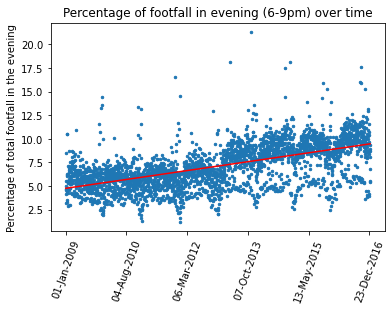

In [86]:
import matplotlib.ticker as mticker
x = result.index
y = result.eve_percentage
fit = np.polyfit(x, y, deg=1)
ticks = make_ticks(result)[0]
tick_locations = make_ticks(result)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x,y, s=6)
fig.subplots_adjust(top=0.85)
ax.xaxis.set_major_locator(mticker.MaxNLocator(18))
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.set_title('Percentage of footfall in evening (6-9pm) over time')
ax.set_ylabel('Percentage of total footfall in the evening')
ax.set_xticks(tick_locations)  
ax.set_xticklabels(ticks, rotation=70)
ax.locator_params(nbins=10, axis='x') 

#### Footfall proportion - 8am-6pm

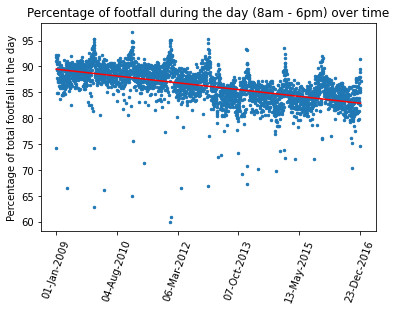

In [87]:
x = result.index
y = result.day_percentage
fit = np.polyfit(x, y, deg=1)
ticks = make_ticks(result)[0]
tick_locations = make_ticks(result)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x,y,s=6)
fig.subplots_adjust(top=0.85)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.set_title('Percentage of footfall during the day (8am - 6pm) over time')
ax.set_ylabel('Percentage of total footfall in the day')
ax.set_xticks(tick_locations)   
ax.set_xticklabels(ticks, rotation=70)
ax.locator_params(nbins=10, axis='x') 

#### Footfall proportion - 9pm-8am

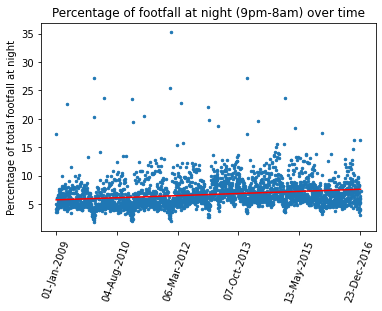

In [114]:
x = result.index
y = result.nighttime_percentage
fit = np.polyfit(x, y, deg=1)
ticks = make_ticks(result)[0]
tick_locations = make_ticks(result)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x,y, s= 6)
fig.subplots_adjust(top=0.85)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.set_title('Percentage of footfall at night (9pm-8am) over time')
ax.set_ylabel('Percentage of total footfall at night')
ax.set_xticks(tick_locations)  
ax.set_xticklabels(ticks, rotation=70)
ax.locator_params(nbins=10, axis='x') 

In summary, it looks like the proportion of footfall in the evening has gone up after the openning of the Trinity Centre.

<a id="methodbackground"></a>
## Method (Background)

Resources:

 - Code: `machine_learning_master.py`
 - Documentation: 
   - `Machine Learning Overall Notes.docx`
   - `machine-learning-tweaking.docx`
   

### Machine Learning Introduction

XXXX Outline the different methods etc.
 

### Machine Learning Workflow

  1.	Split the data into training, validation and testing: 33.333/33.333/33.333
  1.	Select a model using the training data:
        1. Perform K-fold cross validation using each model
        For each union of (k-1) folds:
            - Scale the three weather based columns (in both test and training – using scaling parameters from training data on testing data)
            - Fit a model
            - Evaluate its performance on the test fold 
          
        1. Compare the negative MSE score for each model – select the one with lowest score
        
  1. Tune the hyperparameters using the validation data:
        1. Specify the possible hyper-parameter values in a grid
        1. Perform K-fold cross validation using each parameter value:
        For each union of (k-1) folds:
            - Scale the three weather based columns (in both test and training – using scaling parameters from training data on testing data)
            - Fit a model using those hyperparameters 
            - Evaluate its performance on the test fold 

  1. Evaluate the performance of the selected model and selected hyperparameters on unseen data
      1. Construct overall training data from the union of the training and validation data 
      1. Scale this overall training data, and then train the test data using the parameters from the training 
      1. Fit the model to this training data and evaluate its performance on the test data

  1. Extract information about feature importance

### Feature Scaling

XXXX see `Standardising Variables.docx`

### Removing Outliers

XXXX See `Removing Outliers.docx`

<a id="method"></a>
## Running the Machine Learning Models

This section will document the construction of the machine learning models.

### Preamble

Begin by loading the extra libraries required for machine learning and by defining functions

In [4]:
#import seaborn as sns
#import statsmodels.formula.api as smf

from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Packages needed for regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import xgboost as xgb

In [18]:
# From now on, make the plots look like they've come from ggplot
plt.style.use('ggplot')


def solve(s):
    """Remove suffix (i.e. rd, st) from dates"""
    return re.sub(r'(\d)(st|nd|rd|th)', r'\1', s)                
                 
def normalize(value):
    """Normalise date so it is all expressed on a range of 0 to 1 
    The temperature data contains values which are negative, this is corrected for
    by adding to all values the value of the most negative number, so that everything is 
    above zero"""
    # http://people.revoledu.com/kardi/tutorial/Similarity/Normalization.html 
    # this is to do with normalising negative data - which applies to temperature
    most_neg = - np.amin(value, axis = 0)
    value = value + most_neg
    min_value = np.amin(value, axis = 0)
    max_value = np.amax(value, axis = 0)
    normalized = (value -min_value) / (max_value - min_value)
    return normalized

def split_day(day, hours_wanted):
    """Keep only certain hours in the day"""
    time_split = day.loc[day['Hour'].isin(hours_wanted)]
    return time_split



def make_processed_file (hours_wanted, footfall, bank_hols, school_holidays, 
                         uni_holidays, weather, easter_sundays ):
    """ This is the main function which will be used in other files to produce 
    the processed file.
    
    PARAMETRS:    
     - hours_wanted: used to focus on particular time segments. 
     - footfall: the footfall data (as a DataFrame)
     - bank_hols: times of bank holidays
     - school_holidays: school holidays
     - uni_holidays: university holidays
     - weather: the weather
     - easter_sundays: times of easter sundays
     """
    
    # Import the file and reduce it to only the columns we are interested in and aggregate
    # it at the level of one day 

    # Filter only the needed columns
    day = pd.DataFrame(footfall_f, columns = ['Day', 'Month','Year', 'Hour', 'InCount', 'Day_yr', 'week_no'])
    
    # Split the day file to keep only some of the hours to represent different segments of the economy
    day = split_day(day, hours_wanted)
    del day['Hour']
    
    # Aggregate count data by day
    day = day.groupby(['Day','Month', 'Year', 'Day_yr', 'week_no'], as_index=False).sum()    
    # Create a column for the day of the week
    day['day_week'] = day['Day_yr'].apply(lambda x: x.split('/')[0])  
    # Recreate date column without the day of the week
    day['Day_yr'] = day['Day_yr'].apply(lambda x: x.split('/')[1]) 
    
    ######  Bring in external information and join to the original dataframe. ###### 
    # Festive bank holidays = Christmas Day, New Years Day and Easter Sunday
    bank_hols['UK BANK HOLIDAYS'] = create_date_format(bank_hols['UK BANK HOLIDAYS'], '%d-%b-%y','%d-%b-%Y')
    bank_hols.rename(columns={'UK BANK HOLIDAYS':'Day_yr'}, inplace=True)
    bank_hols['bank_hols'] = 1
    
    # Bring in school holiday information
    school_holidays.rename(columns={'holidays':'Day_yr'}, inplace=True)
    school_holidays['school_holiday'] = 1
    
    # Bring in uni holiday information
    uni_holidays.rename(columns={'holidays':'Day_yr'}, inplace=True)
    uni_holidays['uni_holiday'] = 1
    
    # Bring in weather info
    weather = weather.rename(columns = {"date": 'Day_yr'})
    weather['Day_yr'] = create_date_format(weather['Day_yr'], '%d/%m/%Y','%d-%b-%Y')
    weather = weather.drop (['abnormal_rain', 'high_temp', 'high_wind', 'low_temp', 'wind_speed'], axis = 1)
    
    easter_sundays['easter_Sunday'] = easter_sundays['easter_Sunday'].apply(solve)
    easter_sundays['easter_Sunday'] = create_date_format(easter_sundays['easter_Sunday'], '%d %B %Y','%d-%b-%Y')
    easter_sundays.rename(columns={'easter_Sunday':'Day_yr'}, inplace=True)
    easter_sundays['easter_sunday'] = 1
                  
    # Join the holiday and weather information
    day = day.merge(school_holidays,how='left', on='Day_yr')
    day = day.merge(uni_holidays,how='left', on='Day_yr')
    day = day.merge(bank_hols, how='left', on='Day_yr')
    day = day.merge(easter_sundays, how='left', on='Day_yr')
    # Replace NaNs with 0s (before joining weather data which has lots of NaNs)
    day = day.fillna(0)
    # Join weather
    day = day.merge(weather,how='left', on='Day_yr')
    
    # Remove rows where we have no weather data
    day = day.dropna()
    
    # Create columns for before or after Trinity opened
    trinity_opened= "13-Mar-2013"
    trinity_opened = datetime.datetime.strptime("13-Mar-2013", '%d-%b-%Y')
    day['after_trinity_opened'] = day['Day_yr']#
    day['after_trinity_opened'] = pd.to_datetime(day['after_trinity_opened'], format = '%d-%b-%Y')
    day['after_trinity_opened'] = day['after_trinity_opened'] > trinity_opened
    day['after_trinity_opened'] = day['after_trinity_opened'].astype(int)
    
    ######  For categorical variables create a dataframe containing dummy variables. 
    ###### E.g. for each variable we create a column which is coded as 0 or 1. 
    ###### Join these dataframes on to the original dataframe, and delete the original columns
    months = pd.get_dummies(day['Month'], drop_first = True)
    months.columns = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    days_dayweek = pd.get_dummies(day['day_week'], drop_first = True)
    week_no = pd.get_dummies(day['week_no'])
    del week_no[33]
    days_years = pd.get_dummies(day['Year'], drop_first = False)
    del days_years [2015]
    
    # pd.get_dummies creates columns with names which start with digits. This is not allowed
    # in Python's variable naming conventions. So, we convert all the names to strings and append
    # and underscore and use these to rename the columns

    days_years_names = list(days_years.columns.values)
    days_years_names =[str(i) for i in days_years_names]
    days_years_names_new = ['_' + x for x in days_years_names]
    days_years.columns= [days_years_names_new]
   
    # Join the dummy variables onto the main file
    day= pd.concat([day, days_dayweek, days_years, months, week_no], axis=1)
    
    ######  Final processing and cleaning. ###### 
    # Remove all unneeded columns
    day = day.drop (['Day', 'Month', 'Year', 'day_week', 'week_no'], axis = 1)
    
    # Reset index so there are no missing entries
    day_new = day.reset_index(drop = True)
    
    day_new['week_before_xmas'] = np.where(day_new['Day_yr'].str.contains("24-Dec|23-Dec|22-Dec|21-Dec") == True, 1,0 )
    day_new['week_after_xmas'] = np.where(day_new['Day_yr'].str.contains("29-Dec|30-Dec|31-Dec|01-Jan") == True, 1,0 )    

    day_new = day_new.reset_index(drop = True)
    
    return day_new


# Specify a scaler which will only scale certain columns   
def MinMaxScaler_keepcolnames (scaler, data_to_be_scaled):
    scaled = scaler.transform(data_to_be_scaled)
    X = pd.DataFrame(scaled, columns = data_to_be_scaled.columns)
    return (X)

### Data Preparation

Seperate the data into:

  - Y : the response variable
  - X : the predictor variables
  
The following reads in all the data, creating a big data frame with loads of information about each day. Many of the explanatory variables are binary (e.g. is it a Tuesday? is it a bank holiday?) but some are continuous (e.g. the average daily temperature). This leads to some challenges with scaling, which we'll come on to.

#### Read in the data

In [16]:
# make_processed_file(hours_wanted, footfall, bank_hols, school_holidays, uni_holidays, weather, easter_sundays)

hours_wanted =list(range(0,24))
footfall  = footfall_f
bank_hols = holidays_f
school_holidays = school_hols_f
uni_holidays = uni_holidays_f
weather = weather_f 
easter_sundays =easter_sundays_f


    
# Import the file and reduce it to only the columns we are interested in and aggregate
# it at the level of one day 

# Filter only the needed columns
day = pd.DataFrame(footfall, columns = ['Day', 'Month','Year', 'Hour', 'InCount', 'Day_yr', 'week_no'])

# Split the day file to keep only some of the hours to represent different segments of the economy
day = split_day(day, hours_wanted)
del day['Hour']

# Aggregate count data by day
day = day.groupby(['Day','Month', 'Year', 'Day_yr', 'week_no'], as_index=False).sum()    
# Create a column for the day of the week
day['day_week'] = day['Day_yr'].apply(lambda x: x.split('/')[0])  
# Recreate date column without the day of the week
day['Day_yr'] = day['Day_yr'].apply(lambda x: x.split('/')[1]) 

######  Bring in external information and join to the original dataframe. ###### 
# Festive bank holidays = Christmas Day, New Years Day and Easter Sunday
bank_hols['UK BANK HOLIDAYS'] = create_date_format(bank_hols['UK BANK HOLIDAYS'], '%d-%b-%y','%d-%b-%Y')
bank_hols.rename(columns={'UK BANK HOLIDAYS':'Day_yr'}, inplace=True)
bank_hols['bank_hols'] = 1

# Bring in school holiday information
school_holidays.rename(columns={'holidays':'Day_yr'}, inplace=True)
school_holidays['school_holiday'] = 1

# Bring in uni holiday information
uni_holidays.rename(columns={'holidays':'Day_yr'}, inplace=True)
uni_holidays['uni_holiday'] = 1

# Bring in weather info
weather = weather.rename(columns = {"date": 'Day_yr'})
weather['Day_yr'] = create_date_format(weather['Day_yr'], '%d/%m/%Y','%d-%b-%Y')
weather = weather.drop (['abnormal_rain', 'high_temp', 'high_wind', 'low_temp', 'wind_speed'], axis = 1)

easter_sundays['easter_Sunday'] = easter_sundays['easter_Sunday'].apply(solve)
easter_sundays['easter_Sunday'] = create_date_format(easter_sundays['easter_Sunday'], '%d %B %Y','%d-%b-%Y')
easter_sundays.rename(columns={'easter_Sunday':'Day_yr'}, inplace=True)
easter_sundays['easter_sunday'] = 1

# Join the holiday and weather information
day = day.merge(school_holidays,how='left', on='Day_yr')
day = day.merge(uni_holidays,how='left', on='Day_yr')
day = day.merge(bank_hols, how='left', on='Day_yr')
day = day.merge(easter_sundays, how='left', on='Day_yr')
# Replace NaNs with 0s (before joining weather data which has lots of NaNs)
day = day.fillna(0)
# Join weather
day = day.merge(weather,how='left', on='Day_yr')

# Remove rows where we have no weather data
day = day.dropna()

# Create columns for before or after Trinity opened
trinity_opened= "13-Mar-2013"
trinity_opened = datetime.datetime.strptime("13-Mar-2013", '%d-%b-%Y')
day['after_trinity_opened'] = day['Day_yr']#
day['after_trinity_opened'] = pd.to_datetime(day['after_trinity_opened'], format = '%d-%b-%Y')
day['after_trinity_opened'] = day['after_trinity_opened'] > trinity_opened
day['after_trinity_opened'] = day['after_trinity_opened'].astype(int)

######  For categorical variables create a dataframe containing dummy variables. 
###### E.g. for each variable we create a column which is coded as 0 or 1. 
###### Join these dataframes on to the original dataframe, and delete the original columns
months = pd.get_dummies(day['Month'], drop_first = True)
months.columns = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
days_dayweek = pd.get_dummies(day['day_week'], drop_first = True)
week_no = pd.get_dummies(day['week_no'])
del week_no[33]
days_years = pd.get_dummies(day['Year'], drop_first = False)
del days_years [2015]

# pd.get_dummies creates columns with names which start with digits. This is not allowed
# in Python's variable naming conventions. So, we convert all the names to strings and append
# and underscore and use these to rename the columns

days_years_names = list(days_years.columns.values)
days_years_names =[str(i) for i in days_years_names]
days_years_names_new = ['_' + x for x in days_years_names]
days_years.columns= [days_years_names_new]

# Join the dummy variables onto the main file
day= pd.concat([day, days_dayweek, days_years, months, week_no], axis=1)

######  Final processing and cleaning. ###### 
# Remove all unneeded columns
day = day.drop (['Day', 'Month', 'Year', 'day_week', 'week_no'], axis = 1)

# Reset index so there are no missing entries
day_new = day.reset_index(drop = True)

day_new['week_before_xmas'] = np.where(day_new['Day_yr'].str.contains("24-Dec|23-Dec|22-Dec|21-Dec") == True, 1,0 )
day_new['week_after_xmas'] = np.where(day_new['Day_yr'].str.contains("29-Dec|30-Dec|31-Dec|01-Jan") == True, 1,0 )    

day_new = day_new.reset_index(drop = True)




In [19]:
# Read in data
footfall_f = pd.read_csv(FOOTFALL_FILE)
holidays_f = pd.read_csv("holiday_data/UKbankholidays.csv") # Bank holidays
school_hols_f = pd.read_csv("holiday_data/school_hols_long.csv")
uni_holidays_f = pd.read_csv("holiday_data/uni_hols_long.csv")
easter_sundays_f = pd.read_csv("holiday_data/Easter-Sundays.csv")
weather_f = pd.read_csv("weather_data/overall_weather.csv")

original = make_processed_file( \
                               hours_wanted=list(range(0,24)),  \
                               footfall=footfall_f,  \
                               bank_hols=holidays_f, \
                               school_holidays=school_hols_f, \
                               uni_holidays=uni_holidays_f,  \
                               weather=weather_f, \
                               easter_sundays=easter_sundays_f \
                              )

print(original.head())


        Day_yr  InCount  school_holiday  uni_holiday  bank_hols  \
0  01-Jan-2011    47767             1.0          1.0        0.0   
1  01-Jan-2012    32486             1.0          1.0        0.0   
2  01-Jan-2013    45364             1.0          1.0        1.0   
3  01-Jan-2014    34198             1.0          1.0        1.0   
4  01-Jan-2015    46056             1.0          1.0        1.0   

   easter_sunday  mean_temp  rain  after_trinity_opened  Monday  ...  45  46  \
0            0.0        0.0   0.0                     0       0  ...   0   0   
1            0.0        8.6   2.4                     0       0  ...   0   0   
2            0.0        6.2   0.0                     0       0  ...   0   0   
3            0.0        6.9   1.9                     1       0  ...   0   0   
4            0.0       11.8   0.6                     1       0  ...   0   0   

   47  48  49  50  51  52  week_before_xmas  week_after_xmas  
0   0   0   0   0   0   0                 0          

#### Remove outliers

The model should predict _normal_ footfall. Therefore any days that have extremely high or low footfall should be taken out of the training data. We don't actually want the model to try to predict footfall on unusual days, because the things that make the day unusual (like errors in the camera counters, or the presence of special events) are not captured in the input data.

Outliers are detected using the Median Absolute Deviation method.

In [20]:
def doubleMADsfromMedian(y,thresh=3.5):
    """Find outliers using the Median Average Distance.
    
    VALUE: return a list of true/false denoting whether the element in y is an outlier or not
    
    PARAMETERS:
      - y is a pandas Series, or something like that.
    
    warning: this function does not check for NAs
    nor does it address issues when 
    more than 50% of your data have identical values
    """
    # Calculate the upper and lower limits
    m = np.median(y) # The median
    abs_dev = np.abs(y - m) # The absolute difference between each y and the median
    # The upper and lower limits are the median of the difference
    # of each data point from the median of the data
    left_mad = np.median(abs_dev[y <= m]) # The left limit (median of lower half)
    right_mad = np.median(abs_dev[y >= m]) # The right limit (median of upper half)
    
    # Now create an array where each value has left_mad if it is in the lower half of the data,
    # or right_mad if it is in the upper half
    y_mad = left_mad * np.ones(len(y)) # Initially every value is 'left_mad'
    y_mad[y > m] = right_mad # Now larger values are right_mad

    # Calculate the z scores for each element
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    
    # Return boolean list showing whether each y is an outlier
    return modified_z_score > thresh

# Make a list of true/false for whether the footfall is an outlier
no_outliers = pd.DataFrame(doubleMADsfromMedian(original['InCount']))
no_outliers.columns = ['outlier'] # Rename the column to 'outlier'

# Join to the original footfall data to the list of outliers, then select a few useful columns
join = pd.concat([original, no_outliers], axis = 1)
join = pd.DataFrame(join, columns = ['Day_yr', 'outlier', 'InCount'])

# Choose just the outliers
outliers = join[join['outlier'] == True]
outliers_list = list(outliers['Day_yr']) # A list of the days that are outliers

# Now remove all outliers from the original data
df = original.loc[~original['Day_yr'].isin(outliers_list)]
df = df.reset_index(drop = True)

# Check that the lengths all make sense
assert(len(df) == len(original)-len(outliers_list))

print("I found {} outliers from {} days in total. Removing them leaves us with {} events".format(\
    len(outliers_list), len(join), len(df) ) )

I found 57 outliers from 2179 days in total. Removing them leaves us with 2122 events


#### Set up the data in the correct format

Scikit-learn requires input data to be represented as a list of lists. 

In [21]:
# The predictor variables
Xfull = df.drop(['InCount'], axis =1)

# The variable to be predicted
Yfull = df['InCount'].values

# Store the predictors themselves in a list for future reference
predictors = list(df.drop(['InCount', 'Day_yr'], axis=1).columns)

#### Create Validation Data Sets

The following data sets are created:

 - training (**`train`**) (66%): Used for finding the best models from a set of all possible models
 
 - testing (33%). This split is actually divided again (50:50) and used for:
 
   - hyperparameter tuning (**`validate`**) on the models chosen from step 1.
   
   - testing the final model on totally new data (**`finaltest`**)
  
 - training the final model: the `validate` and `train` data are combined for the final training, before the model is tested on `finaltest`


In [22]:
# Split data into training and test sets
X_train, X_temp, Y_train, Y_temp = \
    train_test_split(Xfull, Yfull, test_size=0.6666, random_state=123)
    
# Split off another training set now to train the hyperparameters using the two best models from above
X_validate, X_finaltest, Y_validate, Y_finaltest = \
    train_test_split(X_temp, Y_temp, test_size=0.5, random_state=123)

# Save copy of the X files with dates and then delete
X_finaltest_date = copy.deepcopy(X_finaltest)

# Clean up
del X_temp, Y_temp, X_finaltest['Day_yr'], X_validate['Day_yr'], X_train['Day_yr']

#### Find the best model

Use k-fold cross validation to evaluate a range of regression algorithms on the training data. 
Use a pipeline for evaluation which first scales the (weather) data. 
Print the results and assess which models perform best.

The following models were trialled: 
  - Decision Tree
  - Random Forest
  - Extra Trees
  - Dummy Regressor
  - Elastic Net CV
  - Passive Aggressive
  - RANSAC
  - SGD
  - TheilSen (_dropped in code below because it takes too long_)
  - K Neighbours
  - LinearRegression
  - XGBoos

In [ ]:
# Define a list of all the models to use
Models = {'DecisionTree' : DecisionTreeRegressor, 'RandomForest': RandomForestRegressor, 
          'ExtraTrees' : ExtraTreesRegressor,'DummyRegressor' :DummyRegressor, 
          'ElasticNetCV' : ElasticNetCV, 'PassiveAggressive' : PassiveAggressiveRegressor,
          # RANSAC': RANSACRegressor, # This one is terrible too
          'SGD': SGDRegressor, 
          #'TheilSen': TheilSenRegressor, # Drop this - it isn't great and takes too long
          'KN': KNeighborsRegressor, 'LinearRegression': LinearRegression,
          'XGBoost': xgb.XGBRegressor}

# Now just run each model, but do this in multiple processes simultaneously to save time.

# This function runs a model, returning a tuple containing:
#  (name, model, r2 (all), median r2, mse (all), median mse, runtime).
# It expects a tuple with (name,model_type)
def run_model( x ):
    name, model_type = x # Unpack the tuple
    # See how long it takes to run this model
    start = thetime.time()
    # Use a pipeline to first scale the inputs (especially the weather)
    model = Pipeline (
        [ ('standardize', MinMaxScaler(feature_range = (0,1))), 
         (name, model_type())]
    )
    # Evaluate the pipeline (run the model)
    kfold = KFold(n_splits=10, random_state=7)
    mse = cross_val_score(model, X_train, Y_train, cv=kfold, scoring = 'neg_mean_squared_error')
    r2 = cross_val_score(model, X_train, Y_train, cv=kfold, scoring = 'r2')
    
    # See how long it took (in seconds)
    runtime = int(thetime.time() - start)
    # Return the results, taking the median of the errors
    return (name, model, r2, np.median(r2), mse, np.median(mse), runtime)

    
# Now call that function simultaneously for each model
p = Pool(processes=None) # A pool of processes (one for each core)
results = p.map(run_model, [(name, model_type) for name, model_type in Models.items()])

# Sort the results by median mse (that's item 5 in the tuple)
results.sort(key=lambda x: x[5], reverse=True)

# Put the results in a nice dictionary and print them
results_dict = {}
txt = "<table><thead><td>Name</td><td>Median R2</td><td>Median MSE</td><td>runtime (sec)</td></thead>"
for name, model, all_r2, r2, all_mse, mse, runtime in results:
    txt += "<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(name, r2, mse, runtime)
    results_dict[name] = (model, all_r2, r2, all_mse, mse, runtime)
txt +="</table>"


display(HTML(txt)) # print as html

In [16]:
# I THINK THIS IS REDUNDANT NOW THAT WE HAVE THE TABLE ABOVE
## Find the errors associated with each model that we just calculated
#r2_result = [] # Store the R2 results
#mse_result = [] # And the mean square error
#for name, model, r2, mse, runtime in results:
#    mse_result.append([name, mse])
#    r2_result.append([name, r2])
# 
#
## Sort and print the results 
#mse_result.sort(key=lambda x: x[1], reverse=True)
#r2_result.sort(key=lambda x: x[1], reverse=True)
#
#txt = "<table><thead><td>Model</td><td>R2</td><td>MSE</td><td>runtime(s)</td></thead>"
#
#print("MSE RESULTS")
#pprint(mse_result)
#print("R2 RESULTS")
#pprint(r2_result)

A bar chart showing the success of each model. Note that especially bad values are surpressed, and for the Mean Square Error the graph actually shows the error for each module minus the worst error so that the numbers are positive.

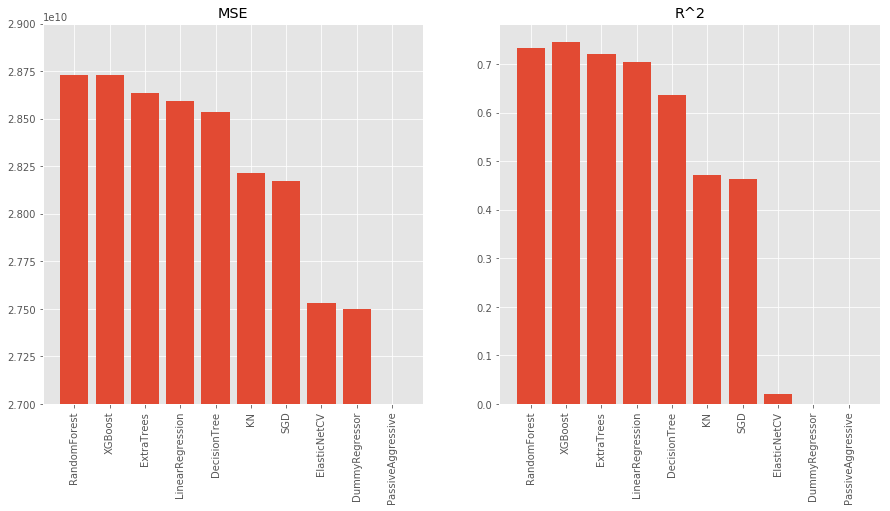

In [17]:
min_mse = min([mse for (name, model, all_r2, r2, all_mse, mse, runtime) in results])
               
x =  [ name for (name, model, all_r2, r2, all_mse, mse, runtime) in results]
y1 = [ mse-min_mse   for (name, model, all_r2, r2, all_mse, mse, runtime) in results]
y2 = [ r2 if r2 > 0 else 0 for (name, model, all_r2, r2, all_mse, mse, runtime) in results]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.set_title("MSE")
#ax1.invert_yaxis()
ax1.bar(range(len(x)), y1)
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x, rotation=90)
ax1.set_ylim([27000000000, 29000000000])

ax2.set_title("R^2")
ax2.bar(range(len(x)), y2)
ax2.set_xticks(range(len(x)))
ax2.set_xticklabels(x, rotation=90)

plt.show()

#del x,y1, y2

#### Tune the Best Models

It looks like *RandomForest* and *XGBoost* are the most accurate predictors, although *LinearRegression* does surprisingly well. 

Now tune their internal parameters ('hyperparameters') to try to improve the predictions further (this isn't relevant to linear regression as that doesn't have tuneable parameters).

Use GridSearchCV to evalaute the performance of a range of hyperparameter values and to identify the best performing one, and the resulting MSE score.

Again, place each model in a pipeline with the scaler.

In [18]:
## Set up a dictionary containing the hyperparameters we want to tune
hyperparameters_rf = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}
hyperparameters_xgb = {'xgbregressor__max_depth': range(1, 11, 2),
                   'xgbregressor__n_estimators' : range(50, 400, 50),
                   'xgbregressor__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
hyperparameters_lr = {}

# Set up the pipeline containing the scalers
pipeline_rf = make_pipeline(MinMaxScaler(feature_range = (0,1)), 
                         RandomForestRegressor(n_estimators=100))
pipeline_xgb = make_pipeline(MinMaxScaler(feature_range = (0,1)),
                         xgb.XGBRegressor(n_estimators=100))
pipeline_lr = make_pipeline(MinMaxScaler(feature_range = (0,1)),
                         LinearRegression())

# Store the scores in a results dictionary (and print them)
final_results = {}
for model_values in [(pipeline_rf,  hyperparameters_rf,  'RandomForest'),
                     (pipeline_xgb, hyperparameters_xgb, 'XGBoost'),
                     (pipeline_lr,  hyperparameters_lr,  'LinearRegression')]:
    
    clf = GridSearchCV(model_values[0], model_values[1], 
                       #cv = None, # Cross-validation method. None means default (3-fold)
                       cv = 10, # positive intiger means k-fold (e.g. 10-fold)
                       #scoring  = 'neg_mean_squared_error', # MSE to calculate score
                       scoring  = 'r2', # MSE to calculate score
                       n_jobs=multiprocessing.cpu_count()) # Run on multiple cores
    
    #clf = GridSearchCV(model_values[0], model_values[1], cv = 10, scoring  = 'r2')
    clf.fit(X_validate, Y_validate)
    name = model_values[2]
    final_results[name] = clf
    print ("Hyperparameter results for {}".format(name))
    print ("\tBest Score: {}".format(clf.best_score_))
    print ("\tBest params: {}".format(clf.best_params_))



Hyperparameter results for RandomForest
	Best Score: 0.7367937849711531
	Best params: {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'auto'}
Hyperparameter results for XGBoost
	Best Score: 0.7973302696546442
	Best params: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 150}
Hyperparameter results for LinearRegression
	Best Score: -3.7584551302556895e+21
	Best params: {}


Chart the results of the final models. Note, see: [GridSearchCV docs](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for information about the things that you can get from the results (e.g. the `cv_results_` member gives lots of information about the scores for each validation step).

Linear Regression diagnostics:
{'mean_fit_time': array([ 0.02600694]),
 'mean_score_time': array([ 0.00133996]),
 'mean_test_score': array([ -3.75845513e+21]),
 'mean_train_score': array([ 0.78938896]),
 'params': ({},),
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([ 0.73025631]),
 'split0_train_score': array([ 0.78944174]),
 'split1_test_score': array([ -2.79290731e+22]),
 'split1_train_score': array([ 0.78862725]),
 'split2_test_score': array([ -9.49667027e+21]),
 'split2_train_score': array([ 0.78705718]),
 'split3_test_score': array([ 0.72292301]),
 'split3_train_score': array([ 0.78981013]),
 'split4_test_score': array([ 0.58634133]),
 'split4_train_score': array([ 0.79330258]),
 'split5_test_score': array([ 0.63760364]),
 'split5_train_score': array([ 0.79832617]),
 'split6_test_score': array([ 0.76129813]),
 'split6_train_score': array([ 0.78548659]),
 'split7_test_score': array([ 0.77993879]),
 'split7_train_score': array([ 0.78580165]),
 'split8_tes

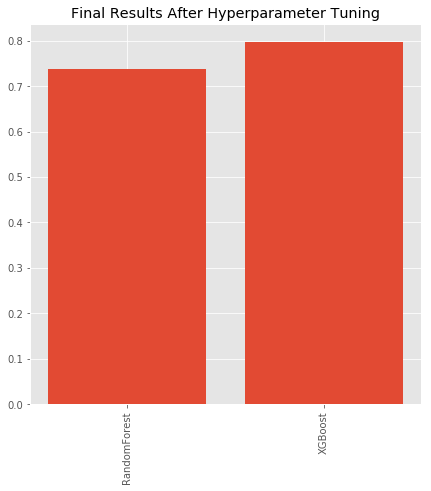

In [19]:
# LinearRegression is sometimes very bad, and I'm not sure why. These explosive errors
# drag up the error. Ignore it from the bar chart below.
# E.g. see the different split scores below:
print("Linear Regression diagnostics:")
pprint(final_results['LinearRegression'].cv_results_)

x = [ name for name in final_results if name != 'LinearRegression']
y = [ final_results[name].best_score_ for name in x]

fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))

ax1.set_title("Final Results After Hyperparameter Tuning")
#ax1.invert_yaxis()
ax1.bar(range(len(x)), y)
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x, rotation=90)

del x, y

#### Choose the best model

  - Choose the model which (with optimised hyperparameters) performed best on the validation data.
  - Fit this model to the whole of the training set. 
  - Scale the data again. 
  - Test the models performance on the final held out testing data

In [34]:
# We have selected XGBoost as being the most appropriate model and discovered the optimum 
# hyper parameters. We can now test the performance of our final model on the untouched 
# testing data to verify its predictive power

# Build the union of the two training sets to make a final training set
X = X_train.append(X_validate)
Y = np.hstack((Y_train,Y_validate))

# Scale the data, using the same scaling constraints from the training data on the test data
scaler = MinMaxScaler(feature_range = (0,1), copy = False).fit(X) 
X = MinMaxScaler_keepcolnames(scaler, X) 
X_finaltest = MinMaxScaler_keepcolnames(scaler, X_finaltest)

# Fit an XGBRegressor model to the training data. 
xgb_model = xgb.XGBRegressor(n_estimators = 200, max_depth = 5, learning_rate = 0.1)
xgb_model = xgb_model.fit(X,Y)
# Use the fitted model to predict the values from the test data
Y_pred = xgb_model.predict(X_finaltest)
# Evaluate the performance of the model at correctly predicting the values of the test data
score = mean_squared_error(Y_finaltest, Y_pred)
score_r2 = r2_score(Y_finaltest, Y_pred)
print("Final scores for XGBoost: MSE: {} R2: {}.".format(score,score_r2))



Final scores for XGBoost: MSE: 382796400.1814735 R2: 0.7533400228808265.


Extricate information about feature importance and plot

mean_temp : 1142
rain : 383
Monday : 131
_2013 : 131
Saturday : 130
_2016 : 130
after_trinity_opened : 123
Thursday : 122
Tuesday : 116
school_holiday : 115
Sunday : 105
_2011 : 97
_2012 : 93
Wednesday : 77
_2014 : 76
uni_holiday : 74
December : 69
48 : 57
bank_hols : 46
November : 45
October : 42


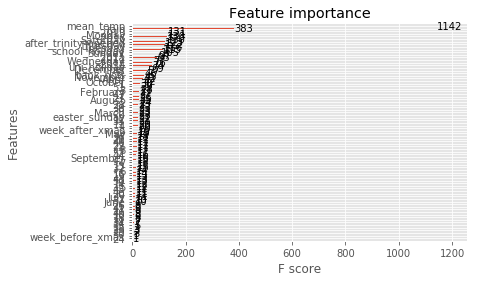

In [40]:
# It's a bit of a pain to get the feature importances. I adapted the code here: 
# https://github.com/dmlc/xgboost/issues/757

feature_importances = xgb_model.booster().get_fscore() # A dictionary of features->scores
sorted_features = sorted(feature_importances.items(), key=operator.itemgetter(1),reverse=True) # Convert into a list of tuples
for (i, (feature,importance)) in enumerate(sorted_features):
    if i > 20: # Only print the first 20 features
        break
    print("{} : {}".format(feature,importance))



# Graphing them is much easier:
fig = xgb.plot_importance(xgb_model, importance_type = 'weight')
fig = fig.get_figure()
#fig.savefig("Plots/weekno_cat_noxmas-eastsun-nyday.png", bbox_inches='tight')

Check difference in result if Random Forest is applied

In [42]:
rf_model = RandomForestRegressor(n_estimators = 200, max_depth = None, max_features= 'auto' )
rf_model = rf_model.fit(X,Y)
Y_pred = rf_model.predict(X_finaltest)
score = mean_squared_error(Y_finaltest, Y_pred)
score_r2 = r2_score(Y_finaltest, Y_pred)
print("Final scores for RandomForest: MSE: {} R2: {}.".format(score,score_r2))

# Also get the feature importances (this is a bit easier than with XGBoost)

importances = rf_model.feature_importances_
# Finds the standard deviation of the importance from the mean
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],axis=0)
# The index values of the variables that would return a list of them in descending size order
indices = np.argsort(importances)[::-1]

# Print, in descending order, the variable plus its importance value and store these results in a table
#for f in range(X.shape[1]):
#    print("%d. %s (%f)" % (f + 1, predictors[indices[f]], importances[indices[f]]))
#randforestfeats = [[predictors[indices[f]], importances[indices[f]]] for f in range(X.shape[1])]
randforestfeats = pd.DataFrame(list(zip(predictors, importances)), columns = ['features', 'RF-score'])
randforestfeats['RF-score'] = randforestfeats['RF-score'].abs()
randforestfeats.sort_values(by = 'RF-score', ascending = False, inplace = True)
randforestfeats

Final scores for RandomForest: MSE: 437514784.4651792 R2: 0.7180815005723133.


,features,RF-score
8,Saturday,0.339144
9,Sunday,0.195933
28,December,0.073648
4,mean_temp,0.060966
5,rain,0.053617
7,Monday,0.022535
17,_2016,0.020811
0,school_holiday,0.018272
11,Tuesday,0.011935
12,Wednesday,0.010601


### Join results back to original data and check known events

Join the dates on to the X final test file, so we have the date predicted count and actual count. So can look at particular dates and see how good predictions are.

Begin by preparing a dataset that contains the original data for a load of dates that we're interested in looking at.

In [62]:
# Create a dataframe that has all the events in it, they're original footfall, and eventually
# the predicted footfall
events = pd.DataFrame()

# Define all the events to check
events_to_check = {'TourdeFrance Depart' : '05-Jul-2014',
                   'xmas_lights_2011' : "10-Nov-2011",'xmas_lights_2012' : "08-Nov-2012",'xmas_lights_2013' : "07-Nov-2013",
                   'xmas_lights_2014' : "13-Nov-2014",'xmas_lights_2015' : "12-Nov-2015",'xmas_lights_2016' : "10-Nov-2016",
                   'light_night_2016_1' : "06-Oct-2016", 'light_night_2016_2' : "07-Oct-2016", 'light_night_2015' : "09-Oct-2015",
                   'light_night_2014' : "03-Oct-2016", 'light_night_2013' : "04-Oct-2013", 'light_night_2012' : "05-Oct-2012",
                   'light_night_2011' : "07-Oct-2011", 'marathon_2016' : "08-May-2016", 'marathon_2015' : "10-May-2015",
                   'marathon_2014' : "11-May-2014", 'marathon_2013' : "12-May-2013", 'marathon_2012' : "13-May-2012",
                   'marathon_2011' : "08-May-2011", 'John Lewis Opening' : "20-Oct-2016", 'Trinity Opening' : "21-Mar-2013",
                   'leeds_fest_2014_thurs' : "21-Aug-2014", 'leeds_fest_2014_sun' : "24-Aug-2014", 'leeds_fest_2014_mon' : "25-Aug-2014",
                   'leeds_fest_2015_thurs' : "27-Aug-2015", 'leeds_fest_2015_sun' : "30-Aug-2015", 'leeds_fest_2015_mon' : "31-Aug-2015",
                   'leeds_fest_2016_thurs' : "25-Aug-2016", 'leeds_fest_2016_sun' : "28-Aug-2016", 'leeds_fest_2016_mon' : "29-Aug-2016", }

# Loop over each event name and data, finding the original footfall data and adding it to
# the 'events' dataframe
for (event_name,event_date) in events_to_check.items():
    # Find the row in the original data that match the day we're after for this event
    event_impact = original.loc[original['Day_yr'] == event_date]
    event_impact.insert(0,'Event', event_name) # Add the name of the event
    events = events.append(event_impact) # Add this row of data to the 'events' dataframe

print("Will look at the following events: \n"+str(events[ ['Event','Day_yr'] ]))
    
# Extract the event names from the dataframe of all event information (not sure why Molly does this)
event_names = pd.DataFrame(events, columns = ['Event'])
event_names = event_names.reset_index(drop = True)
del events['Event']    



Will look at the following events: 
                      Event       Day_yr
319     TourdeFrance Depart  05-Jul-2014
697        xmas_lights_2011  10-Nov-2011
554        xmas_lights_2012  08-Nov-2012
483        xmas_lights_2013  07-Nov-2013
916        xmas_lights_2014  13-Nov-2014
845        xmas_lights_2015  12-Nov-2015
702        xmas_lights_2016  10-Nov-2016
408      light_night_2016_1  06-Oct-2016
480      light_night_2016_2  07-Oct-2016
623        light_night_2015  09-Oct-2015
197        light_night_2014  03-Oct-2016
264        light_night_2013  04-Oct-2013
333        light_night_2012  05-Oct-2012
475        light_night_2011  07-Oct-2011
522           marathon_2016  08-May-2016
665           marathon_2015  10-May-2015
736           marathon_2014  11-May-2014
807           marathon_2013  12-May-2013
878           marathon_2012  13-May-2012
517           marathon_2011  08-May-2011
1416     John Lewis Opening  20-Oct-2016
1443        Trinity Opening  21-Mar-2013
1474  leeds_fest_2014

 Define a function that makes it easy to do predictions

In [68]:
def make_prediction (f, real_vals, model):
    """Make a prediction using a given model. 
    
    PARAMETERS
      - f:         A dataframe with all the original data
      - real_vals: A dataframe with the year and (actual) footfall
      - model:     The model that will be used to make the prediction
    
    VALUE
      - A pandas datagrame with the day of the prediction, the real value, the predicted value, 
      and the differences (both absolute and percentage)
    """
    # Prepare a dataframe that will be used to make the prediction. It will need to include 
    # everything except the date and footfall count (obviously these aren't used to make the prediction)
    everything = copy.deepcopy(df)
    everything = everything.drop(['Day_yr', 'InCount'],axis = 1).reset_index(drop = True)
    
    #Make a precit
    prediction = pd.DataFrame(  model.predict(everything)  )
    
    # Compare predictions to real values
    comparison_xgb = pd.concat([real_vals,prediction], axis =1, ignore_index = True)
    comparison_xgb.columns = ['Day_yr', 'real_value', 'xgb']
    # Add difference and percentage difference columns
    comparison_xgb['xgb_difference']= comparison_xgb['xgb'] - comparison_xgb['real_value'] 
    comparison_xgb['xgb_%difference']= comparison_xgb['xgb_difference']/ comparison_xgb['real_value'] * 100
    #comparison_xgb = pd.concat([comparison_xgb,everything], axis =1)
    return comparison_xgb


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b775470>]], dtype=object)

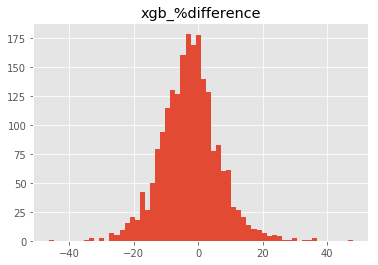

In [71]:
# For convenience save the date and original footfall for comparison shortly
# (Note: 'df' is the original data minus the outliers )
real_vals = pd.DataFrame(df, columns = ['Day_yr', 'InCount']).reset_index(drop = True)

# Run the model on the original data:
predict = make_prediction (df, real_vals, xgb_model)

# Now run it just on the events
predict_events = make_prediction (events, real_vals, xgb_model)

XXXX HERE - NEED TO CONCATENATE THE COLUMNS CORRECTLY
#predict_events = pd.concat([predict_events,event_names], axis = 1)

# Create histograms comparing the error distribution
histo_xgb = pd.DataFrame(predict, columns = ['xgb_%difference'])
histo_xgb = histo_xgb.loc[histo_xgb['xgb_%difference'] < 100]
histo_xgb = histo_xgb.loc[histo_xgb['xgb_%difference'] > -100]
pd.DataFrame.hist(histo_xgb, bins = 60)




<a id="results"></a>
## Results

XXXX

<a id="conclusions"></a>
## Conclusions

XXXX